# Identify interactions between odor and W_AIR representations in G4

In [1]:
%matplotlib inline
from copy import deepcopy
from itertools import product as cproduct
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
from sklearn.linear_model import Lasso, LinearRegression, Ridge

from aux import Generic
from aux import make_extended_predictor_matrix, calc_r2
from data import DataLoader, random_chunk_split
from db import make_session, d_models
from plot import set_font_size

import CONFIG as C

# Define function to fit filters and store filtered values for each trial

In [2]:
def fit_filters(trial, x_names, y_names, x_wdws, models):
    """
    Fit 1D linear filters mapping individual inputs (x_names) to
    outputs (y_names).
    
    :param x_names: tuple of input names
    :param y_names: tuple of output names; must have same length as x_names
    :param x_wdws: dict of (start, end) windows to use in fitting filters;
        keys are (x_name, y_name) pairs
    :param models: dict of models to use when fitting; each should have a .fit method
    
    :return: FitResult object with attributes:
            trial
            
            x_names
            y_names
            
            x_wdws
            x_wdws_dsct
            
            r2s
            y_hats
            
            t_hs
            hs
    """
    t = getattr(trial.dl, 't')
    
    assert len(x_names) == len(y_names)
    
    for x_name, y_name in zip(x_names, y_names):
        
        assert (x_name, y_name) in x_wdws
        assert (x_name, y_name) in models
    
    # prepare result dict
    fit_result_dict = {
        'trial': trial,
        'x_names': x_names,
        'y_names': y_names,
        'x_wdws': x_wdws,
        'x_wdws_dsct': {},
        'r2s': {},
        'y_hats': {},
        't_hs': {},
        'hs': {},
    }
    
    # loop over filter pairs
    for x_name, y_name in zip(x_names, y_names):
        
        x_wdw = x_wdws[(x_name, y_name)]
        model = models[(x_name, y_name)]
        
        # munge data into arguments for LinearRegression.fit
        x = getattr(trial.dl, x_name)

        vs = {x_name: x}

        x_wdw_dsct = (int(round(x_wdw[0] / C.DT)), int(round(x_wdw[1] / C.DT)))
        wdws_dsct = {x_name: x_wdw_dsct}
        
        t_h = np.arange(*x_wdw_dsct) * C.DT

        order = [x_name]
    
        x_xtd = make_extended_predictor_matrix(vs=vs, windows=wdws_dsct, order=order)
        y = getattr(trial.dl, y_name)
    
        # get valid mask
        valid = np.all(~np.isnan(x_xtd), axis=1) & (~np.isnan(y))
        
        # fit model if possible
        if np.sum(valid) > x_xtd.shape[1]:

            # fit model
            rgr = model()
            rgr.fit(x_xtd[valid], y[valid])

            # make predictions
            y_hat = np.nan * np.zeros(y.shape)
            y_hat[valid] = rgr.predict(x_xtd[valid])

            r2 = calc_r2(y[valid], y_hat[valid])
            
            # get filter coefficients
            h = rgr.coef_
            
        else:
            print('Not enough data to fit model.')

            r2 = np.nan
            y_hat = np.nan * np.zeros(y.shape)
            
            h = np.nan * np.ones(x_xtd.shape[1])

        # store results
        fit_result_dict['r2s'][(x_name, y_name)] = r2
        fit_result_dict['y_hats'][(x_name, y_name)] = y_hat
        fit_result_dict['t_hs'][(x_name, y_name)] = t_h
        fit_result_dict['hs'][(x_name, y_name)] = h
        
    return Generic(**fit_result_dict)

# Test filter-fitting function

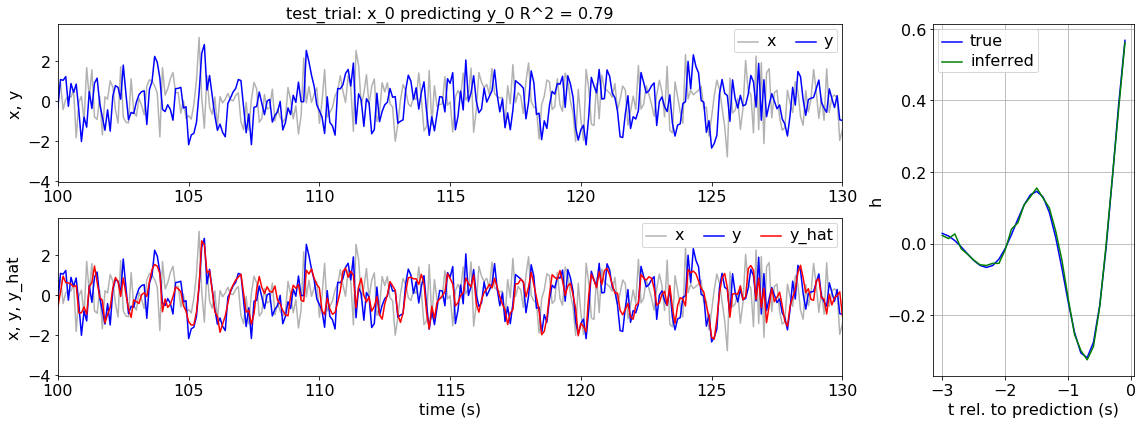

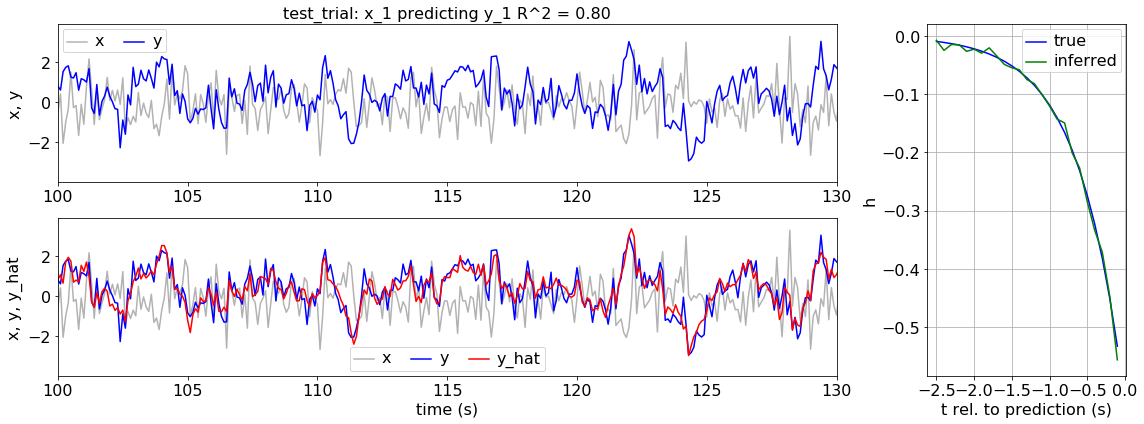

In [3]:
def test_fit_filter(*t_lim):
    np.random.seed(0)
    
    # mock data
    t = np.arange(0, 300, C.DT)
    
    # first relation
    x_0 = np.random.normal(0, 1, t.shape)
    
    t_h_0 = np.arange(-3, 0, C.DT)
    h_0 = np.exp(t_h_0/1) * np.cos(4 * t_h_0)
    h_0 /= np.linalg.norm(h_0)
    
    y_0 = np.convolve(x_0, np.concatenate([h_0, np.zeros(h_0.shape)])[::-1], mode='same') \
        + np.random.normal(0, .5, t.shape)
        
    # second relation
    x_1 = np.random.normal(0, 1, t.shape)
    
    t_h_1 = np.arange(-2.5, 0, C.DT)
    h_1 = -np.exp(t_h_1/0.6)
    h_1 /= np.linalg.norm(h_1)
    
    y_1 = np.convolve(x_1, np.concatenate([h_1, np.zeros(h_1.shape)])[::-1], mode='same') \
        + np.random.normal(0, .5, t.shape)
    
    # mock data loader
    dl = Generic(t=t, x_0=x_0, y_0=y_0, x_1=x_1, y_1=y_1)
    
    # mock trial
    trial = Generic(name='test_trial', dl=dl)
    
    # fit function
    rslt = fit_filters(
        trial=trial,
        x_names=('x_0', 'x_1'),
        y_names=('y_0', 'y_1'),
        x_wdws={
            ('x_0', 'y_0'): (-3, 0),
            ('x_1', 'y_1'): (-2.5, 0),
        },
        models={
            ('x_0', 'y_0'): LinearRegression,
            ('x_1', 'y_1'): LinearRegression,
        })
    
    for x, y, x_name, y_name, t_h, h in zip(
            [x_0, x_1], [y_0, y_1], ['x_0', 'x_1'], ['y_0', 'y_1'], [t_h_0, t_h_1], [h_0, h_1]):
    
        # plot true and found filters
        gs = gridspec.GridSpec(2, 4)

        fig = plt.figure(figsize=(16, 6), tight_layout=True)
        ax_0 = fig.add_subplot(gs[0, :3])
        ax_1 = fig.add_subplot(gs[1, :3], sharex=ax_0)
        ax_2 = fig.add_subplot(gs[:, 3])

        # plot x, y, y_hat_train, y_hat_test
        ax_0.plot(t, x, color='k', alpha=0.3)
        ax_0.plot(t, y, color='b')

        ax_0.set_ylabel('x, y')
        ax_0.set_title('{0}: {1} predicting {2} R^2 = {3:.2f}'.format(
            rslt.trial.name, x_name, y_name, rslt.r2s[(x_name, y_name)]))

        ax_0.legend(['x', 'y'], ncol=2)

        ax_1.plot(t, x, color='k', alpha=0.3)
        ax_1.plot(t, y, color='b')
        ax_1.plot(t, rslt.y_hats[(x_name, y_name)], color='r')

        ax_1.set_xlim(*t_lim)

        ax_1.set_xlabel('time (s)')
        ax_1.set_ylabel('x, y, y_hat')
        ax_1.legend(['x', 'y', 'y_hat'], ncol=4)

        # plot filters
        ax_2.plot(t_h, h, color='b')
        ax_2.plot(rslt.t_hs[(x_name, y_name)], rslt.hs[(x_name, y_name)], color='g')

        ax_2.grid()

        ax_2.set_xlabel('t rel. to prediction (s)')
        ax_2.set_ylabel('h')

        ax_2.legend(['true', 'inferred'], loc='best')

        for ax in [ax_0, ax_1, ax_2]:
            set_font_size(ax, 16)
        
test_fit_filter(100, 130)

# Fit filters

In [4]:
EXPTS = ['white_odor_fluct']

X_NAMES = ('odor_binary', 'w_air')
Y_NAMES = ('g4s', 'g4d')

X_WDWS = {
    ('odor_binary', 'g4s'): (-3, 0),
    ('w_air', 'g4d'): (-3, 0)
}

MODELS = {
    ('odor_binary', 'g4s'): LinearRegression,
    ('w_air', 'g4d'): lambda: Lasso(alpha=0.5),
}

PLOTS = [
    (('odor_binary', 'g4s'), ('w_air', 'g4d'), 'g4s'),
    (('odor_binary', 'g4s'), ('w_air', 'g4d'), 'g4d'),
]

X_LABEL = 'filtered odor'
Y_LABEL = 'filtered w_air'

## Load trials

In [5]:
# load trials
session = make_session()
trials = session.query(d_models.Trial).filter(
    d_models.Trial.expt.in_(EXPTS)).all()
session.close()

# load data and create a moving average 
for trial in trials:
    trial.dl = DataLoader(trial, 0, None)

## Run fits

In [6]:
rslts = {trial.name: fit_filters(trial, X_NAMES, Y_NAMES, X_WDWS, MODELS) for trial in trials}

## Make per-trial scatter plots

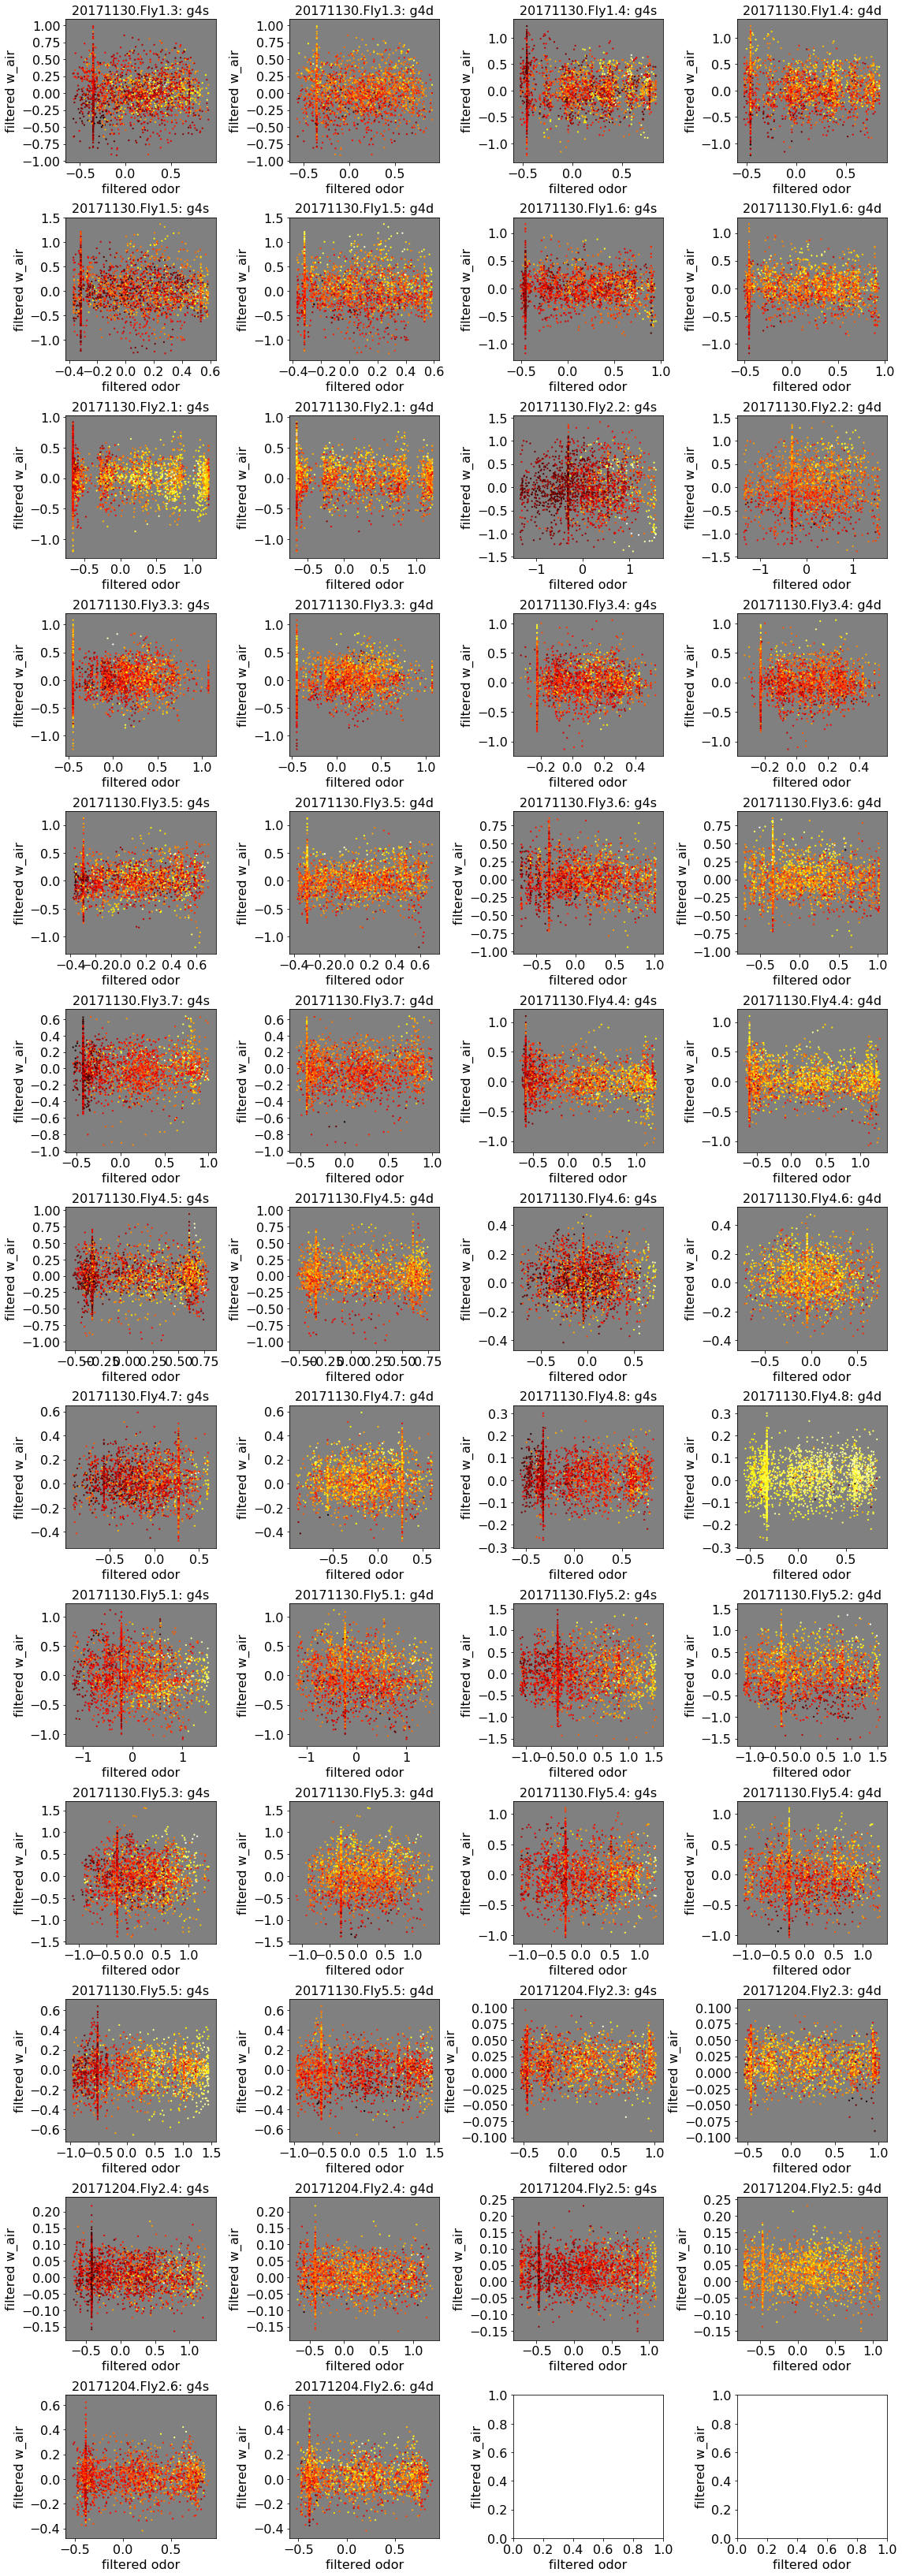

In [7]:
AX_W = 4
AX_H = 3.5

n_rows = int(np.ceil(len(rslts)/2))

fig, axs = plt.subplots(n_rows, 4, figsize=(4*AX_W, n_rows*AX_H), tight_layout=True, squeeze=False)
ax_pairs = np.arange(axs.size).reshape(-1, 2)

for trial, ax_pair in list(zip(trials, ax_pairs)):
    
    for (x_key, y_key, z_name), ax_ctr in zip(PLOTS, ax_pair):
        
        x = rslts[trial.name].y_hats[x_key]
        y = rslts[trial.name].y_hats[y_key]
        
        z = getattr(trial.dl, z_name)
        
        ax = axs.flatten()[ax_ctr]
        
        ax.scatter(x, y, c=z, vmin=np.nanmin(z), vmax=np.nanmax(z), s=5, lw=0, cmap='hot')
        ax.set_facecolor('gray')
        
        ax.set_title('{}: {}'.format(trial.name, z_name))
        
for ax in axs.flatten():
    
    ax.set_xlabel(X_LABEL)
    ax.set_ylabel(Y_LABEL)
    
    set_font_size(ax, 16)

## Quantify nonlinear interactions between filtered stimuli

In [8]:
from scipy.stats import spearmanr
from aux import split_data

BINS = 6

# define bins (x_key, y_key, z_name, variable to bin)
BIN_SPECS = [
    {
        'fixed_key': ('odor_binary', 'g4s'),
        'binned_key': ('w_air', 'g4d'),
        'z_name': 'g4s',
    },
    {
        'fixed_key': ('w_air', 'g4d'),
        'binned_key': ('odor_binary', 'g4s'),
        'z_name': 'g4d',
    },
]

slps = {trial.name: [None, None] for trial in trials}
iis = {trial.name: [None, None] for trial in trials}

for trial in trials:
    
    # loop over plots
    for bs_ctr, bin_spec in enumerate(BIN_SPECS):
        
        fixed = rslts[trial.name].y_hats[bin_spec['fixed_key']]
        binned = rslts[trial.name].y_hats[bin_spec['binned_key']]
        
        z = getattr(trial.dl, bin_spec['z_name'])
        
        # loop over data percentiles
        pctl_masks = split_data(binned, BINS)
        slps_ = []
        
        for mask in pctl_masks:
            
            slp = linregress(fixed[mask], z[mask])[0] if any(mask) else np.nan
            slps_.append(slp)
        
        # calculate interaction index
        ii = spearmanr(range(BINS), slps_)[0] if np.sum(~np.isnan(slps_)) > 2 else np.nan

        # store results for this trial
        slps[trial.name][bs_ctr] = slps_
        iis[trial.name][bs_ctr] = ii

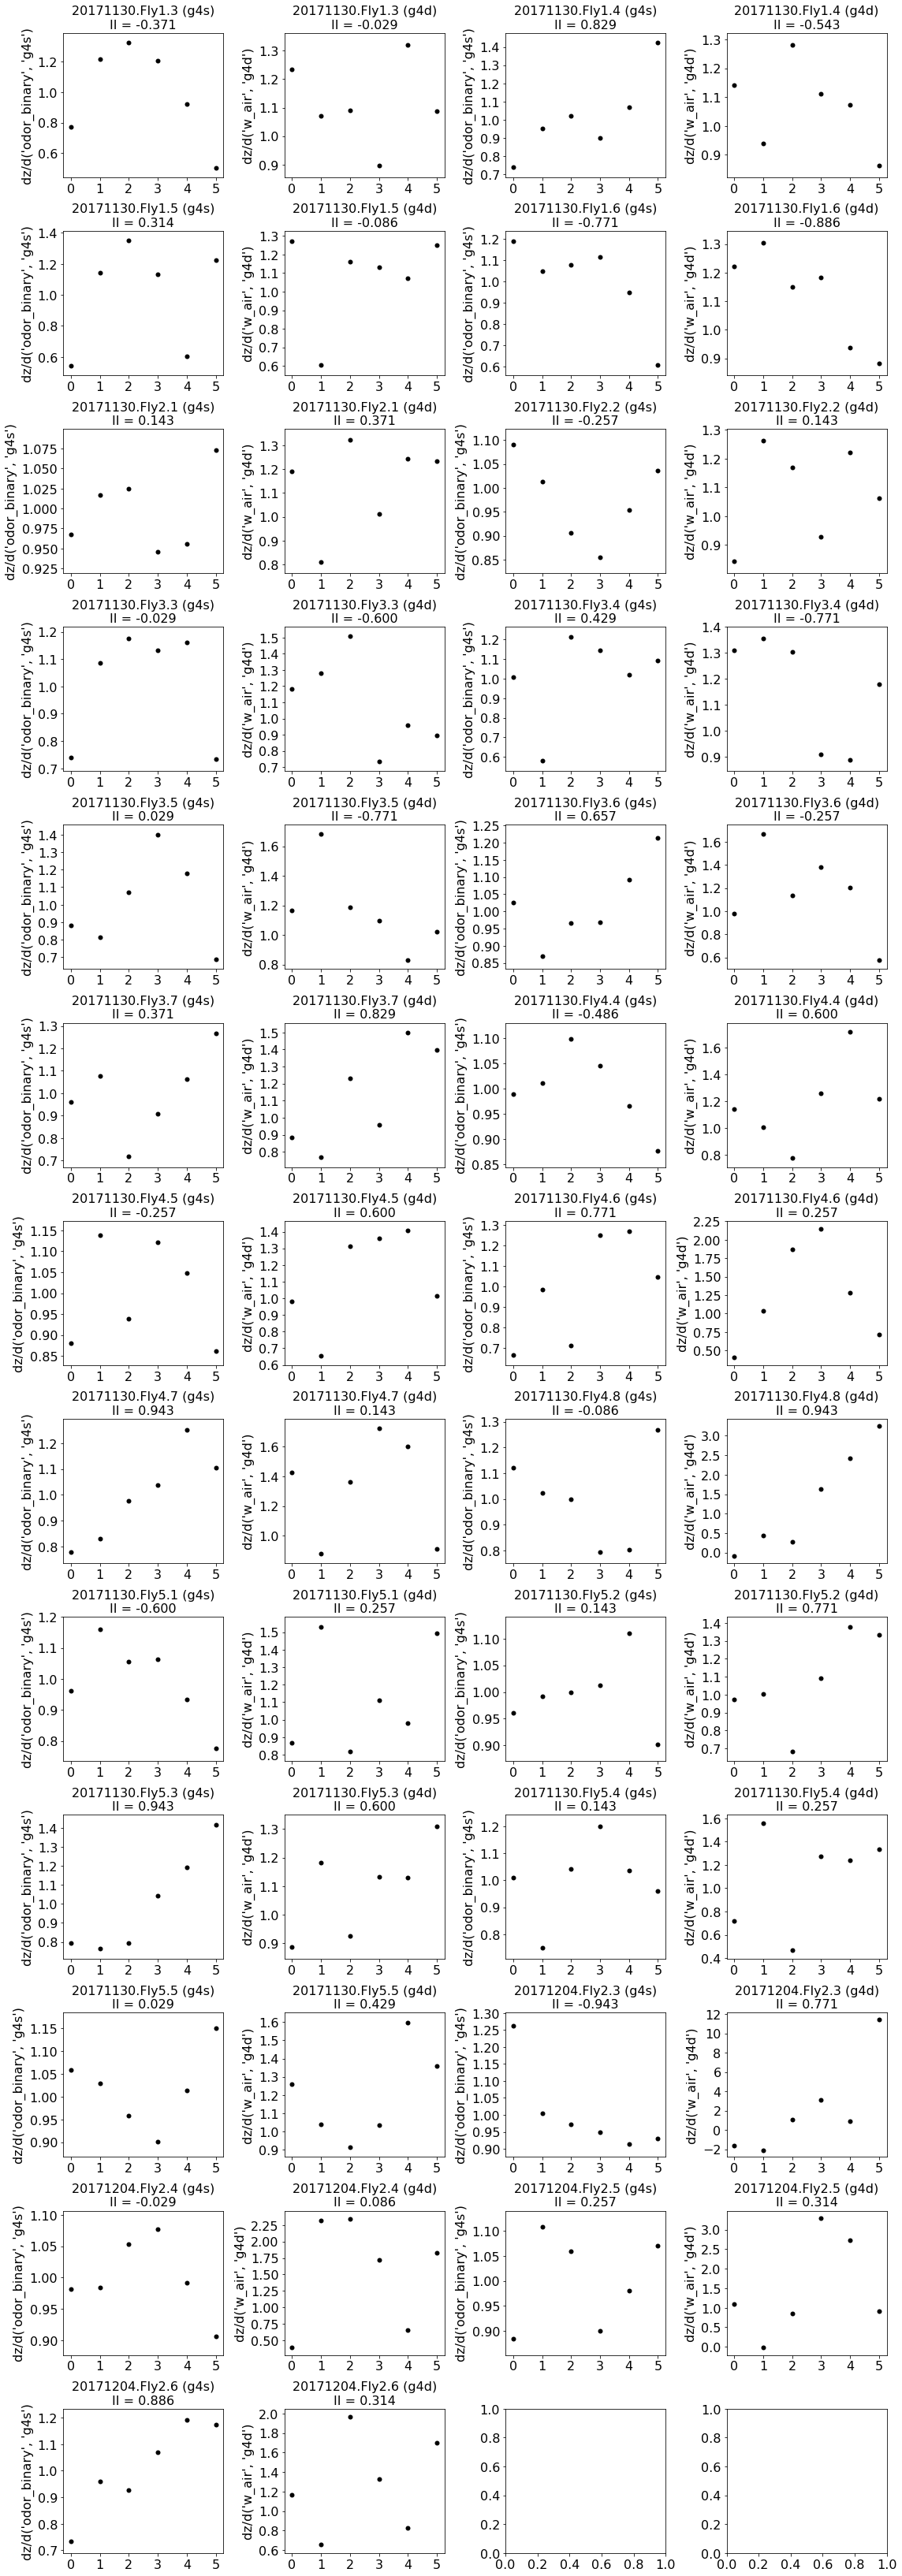

In [9]:
# plot results per trial
fig, axs = plt.subplots(n_rows, 4, figsize=(4*AX_W, n_rows*AX_H), tight_layout=True, squeeze=False)
ax_pairs = np.arange(axs.size).reshape(-1, 2)

for trial, ax_pair in zip(trials, ax_pairs):
    
    for bs_ctr, bin_spec in enumerate(BIN_SPECS):
        
        slps_ = slps[trial.name][bs_ctr]
        ii = iis[trial.name][bs_ctr]
        
        ax = axs.flatten()[ax_pair[bs_ctr]]
        
        ax.scatter(range(BINS), slps_, c='k', lw=0)
        
        ax.set_xlabel(''.format(bin_spec['binned_key']))
        ax.set_ylabel('dz/d{}'.format(bin_spec['fixed_key']))
        
        ax.set_title('{0} ({1})\nII = {2:.3f}'.format(trial.name, bin_spec['z_name'], ii))
        
for ax in axs.flatten():
    set_font_size(ax, 16)

## Calculate interaction statistics across trials

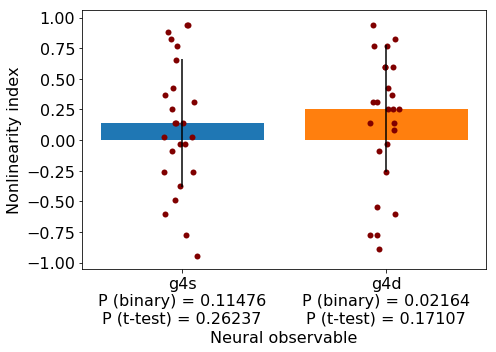

In [23]:
from scipy.stats import binom, ttest_1samp

fig, ax = plt.subplots(1, 1, figsize=(7, 5), tight_layout=True)

x_tick_labels = []

for bs_ctr, bin_spec in enumerate(BIN_SPECS):
    
    # plot interaction idxs
    iis_ = np.array([iis[trial.name][bs_ctr] for trial in trials])
    
    mean = np.nanmean(iis_)
    median = np.nanmedian(iis_)
    std = np.nanstd(iis_)
    
    ## get p-value based on binomial distribution
    iis_not_nan = iis_[~np.isnan(iis_)]
    n = len(iis_not_nan)
    k = np.sum(iis_not_nan > 0)
    
    cdf = binom.cdf(k, n, 0.5)
    p_val_b = min(cdf, 1 - cdf)
    p_val_t = ttest_1samp(iis_not_nan, 0)[1]
    
    ## plot bar
    ax.bar([bs_ctr], [median], yerr=[std], align='center', zorder=0)
    ax.scatter(
        bs_ctr * np.ones(len(iis_)) + np.random.uniform(-.1, .1, len(iis_)),
        iis_, c=(0.5, 0, 0), lw=0, zorder=1)
    
    label = '{0}\nP (binary) = {1:.5f}\nP (t-test) = {2:.5f}'.format(
        bin_spec['z_name'], p_val_b, p_val_t)
    
    x_tick_labels.append(label)
    
ax.set_xticks(range(len(BIN_SPECS)))
ax.set_xticklabels(x_tick_labels)

ax.set_xlabel('Neural observable')
ax.set_ylabel('Nonlinearity index')

ax.set_title('')

set_font_size(ax, 16)

### List trials by name/interaction index to see if negative interaction indices correspond to trials with ugly filters

In [22]:
cols = ['iis ({})'.format(bs['z_name']) for bs in BIN_SPECS]
df = pd.DataFrame(columns=cols)

for trial_name, iis_ in iis.items():
    df.loc[trial_name] = iis_
    
df

,iis (g4s),iis (g4d)
20171130.Fly1.3,-0.371429,-0.028571
20171130.Fly1.4,0.828571,-0.542857
20171130.Fly1.5,0.314286,-0.085714
20171130.Fly1.6,-0.771429,-0.885714
20171130.Fly2.1,0.142857,0.371429
20171130.Fly2.2,-0.257143,0.142857
20171130.Fly3.3,-0.028571,-0.600000
20171130.Fly3.4,0.428571,-0.771429
20171130.Fly3.5,0.028571,-0.771429
20171130.Fly3.6,0.657143,-0.257143


Unfortunately, comparing this list with the trial-specific filters from [2A_sensory_filters_2D](2A_sensory_filters_2D.ipynb) shows that trials with negative iis (g4d) values actually appear to have reasonable filters, and trials with zero-valued filters have positive iis. This indicates that excluding the trials with zero-valued filters would actually make the effect appear even weaker. Thus, this analysis has failed to show a significant interaction effect.